In [3]:
import pickle
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import statistics as st
import os
import glob
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
Path="/media/ilker/Ilker/CRAB/07.09.22/SPE/pmt1/1/raw/*.csv"
files = glob.glob(Path,recursive=True)

In [4]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
def getValues(files,skip,nFiles=-1,findex=0,single=False):
    theone={}
    if(single):
        values={"time":np.array([]),"voltage":np.array([])}
        with open(files[findex]) as f:
            for i in range(0,skip):
                try:
                    next(f)
                except:
                    continue
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values["time"]=np.append(values["time"],float(splitline[0]))
                values["voltage"]=np.append(values["voltage"],float(splitline[1]))
        theone[0]=values
        f.close()
        
    else:
        count=0
        for k in files:
            values={"time":np.array([]),"voltage":np.array([])}
            with open(k) as f:
                for i in range(0,skip):
                    try:
                        next(f)
                    except:
                        continue
                lines=f.readlines()
                for line in lines:
                    splitline=line.split(",")
                    values["time"]=np.append(values["time"],float(splitline[0]))
                    values["voltage"]=np.append(values["voltage"],float(splitline[1]))
            theone[count]=values
            count+=1
            f.close()
            if(nFiles==count): 
                break

    return theone

def Histogram(data,xlabel,ylabel,title,figsize=(12,8),dpi=300,bins=3):
    plt.figure(figsize=figsize,dpi=dpi)
    plt.hist(data,bins=bins)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
def WriteToFile(x,y,txtfile):
    with open(txtfile,"w") as f:
        for i in range(0,len(x)):
            s=str(x[i]) + " " +str(y[i]) +"\n"
            f.write(s)

def getArea(pmt,xlow,xhigh,minpulse=9999,p=True):
 
    ### This is for removing DC offset
    MaskTime=pmt["time"]<=xlow
    DataNoOffset=pmt["voltage"]-st.mean(pmt["voltage"][MaskTime])
    datamin=np.min(DataNoOffset)
    if(datamin>=minpulse and minpulse!=9999): return -1
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(pmt["time"],DataNoOffset,label="Signal DC-removed")
        plt.plot(pmt["time"],pmt["voltage"],label="Signal")
        plt.axvline(xlow)
        plt.axvline(xhigh)
        plt.ylabel("Voltage(V)")
        plt.xlabel("Time(s)")
        plt.legend()
        plt.show()

    DataMask=np.where(np.logical_and(pmt["time"]>=xlow,pmt["time"]<=xhigh))
    x=pmt["time"][DataMask]
    y=DataNoOffset[DataMask]
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(x,y)
        plt.show()

    dt=pmt["time"][DataMask][1:]-pmt["time"][DataMask][:-1]
    area=np.trapz(DataNoOffset[DataMask],dx=dt)
    g=gain(area,50,1,1.62e-19)
    return area,g

def MultiAreaGain(data,xlow,xhigh,minpulse,p=False):
    area=np.array([])
    gain=np.array([])
    for key in data:
        result=getArea(data[key],xlow,xhigh,minpulse=minpulse,p=p)
        if(result!=-1):
            area=np.append(area,result[0])
            gain=np.append(gain,result[1])
    values=np.array([area,gain])
    
    return values
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             if(file[:2]=="C2" or file[:2]=="C1" ):
                filelist.append(os.path.join(root,file))
    return filelist

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getPulseHeight(pmt,xlow,xhigh,minpulse=9999,p=True):
 
    ### This is for removing DC offset
    MaskTime=pmt["time"]<=xlow
    DataNoOffset=pmt["voltage"]-st.mean(pmt["voltage"][MaskTime])
    datamin=np.min(DataNoOffset)
    if(datamin>=minpulse and minpulse!=9999): return -1
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(pmt["time"],DataNoOffset,label="Signal DC-removed")
        plt.plot(pmt["time"],pmt["voltage"],label="Signal")
        plt.axvline(xlow)
        plt.axvline(xhigh)
        plt.legend()
        plt.show()

    DataMask=np.where(np.logical_and(pmt["time"]>=xlow,pmt["time"]<=xhigh))
    x=pmt["time"][DataMask]
    y=DataNoOffset[DataMask]
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(x,y)
        plt.show()

    dt=pmt["time"][DataMask][1:]-pmt["time"][DataMask][:-1]
    pulseheightGate=np.min(DataNoOffset[DataMask])
    pulseheight=np.min(DataNoOffset)

    return pulseheight,pulseheightGate

def MultiPulseHeightDist(data,xlow,xhigh,minpulse,p=False):
    pulseheightGate=np.array([])
    pulseheight=np.array([])
    for key in data:
        result=getPulseHeight(data[key],xlow,xhigh,minpulse=minpulse,p=p)
        if(result!=-1):
            pulseheight=np.append(pulseheight,result[0])
            pulseheightGate=np.append(pulseheightGate,result[1])
    values=np.array([pulseheight,pulseheightGate])
    
    return values
def HistIT(data,title,b,xlabel,xline=0):
    plt.figure(figsize=(12,8),dpi=300)
    plt.title(title)
    plt.ylabel("Number of Events")
    plt.xlabel(xlabel)
    plt.hist(data,bins=b)
    plt.axvline(xline,color="red")
    plt.semilogy()
    mean=st.mean(data)
    stdev=st.stdev(data)
    print(f"mean = {mean} stdev = {stdev}")
def HistAreandGain(data,title,b):
    plt.figure(figsize=(12,8),dpi=300)
    plt.title(title+" Gain")
    plt.ylabel("Number of Events")
    plt.xlabel("Gain")
    plt.hist(data[1],bins=b)
    plt.semilogx()
    mean=st.mean(data[1])
    stdev=st.stdev(data[1])
    print(f"Gain mean = {mean} stdev = {stdev}")
    
    plt.figure(figsize=(12,8),dpi=300)
    plt.title(title+" Area")
    plt.ylabel("Number of Events")
    plt.xlabel("Area(wb)")
    plt.hist(data[0],bins=b)
    plt.semilogx()
    mean=st.mean(data[0])
    stdev=st.stdev(data[0])
    print(f"Area mean = {mean} stdev = {stdev}")
    


In [4]:
correspondingPmt1Files=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/SPE/pmt1")
Pmt3Files=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/SPE/pmt3")
pp="/media/ilker/Ilker/CRAB/Analysis/CRAB/Main/SimAnalysis/"

In [5]:
### FILES
## PMT1
if(not(os.path.exists(pp+"PMT1_LED_SPE_data.p"))): 
    pmt1=getValues(Pmt1Files,5)
    PickleITDump(pmt1,pp+"PMT1_LED_SPE_data.p")
else:
    pmt1=PickleITRead(pp+"PMT1_LED_SPE_data.p")
## PMT3
if(not(os.path.exists(pp+"PMT3_LED_SPE_data.p"))):
    pmt3=getValues(Pmt3Files,5)
    PickleITDump(pmt3,pp+"PMT3_LED_SPE_data.p")
else:
    pmt3=PickleITRead(pp+"PMT3_LED_SPE_data.p")



In [6]:
g=MultiAreaGain(pmt1,0.3e-7,1e-7,-0.0004)  ## xlow,xhigh (time) , minpulse(volt)

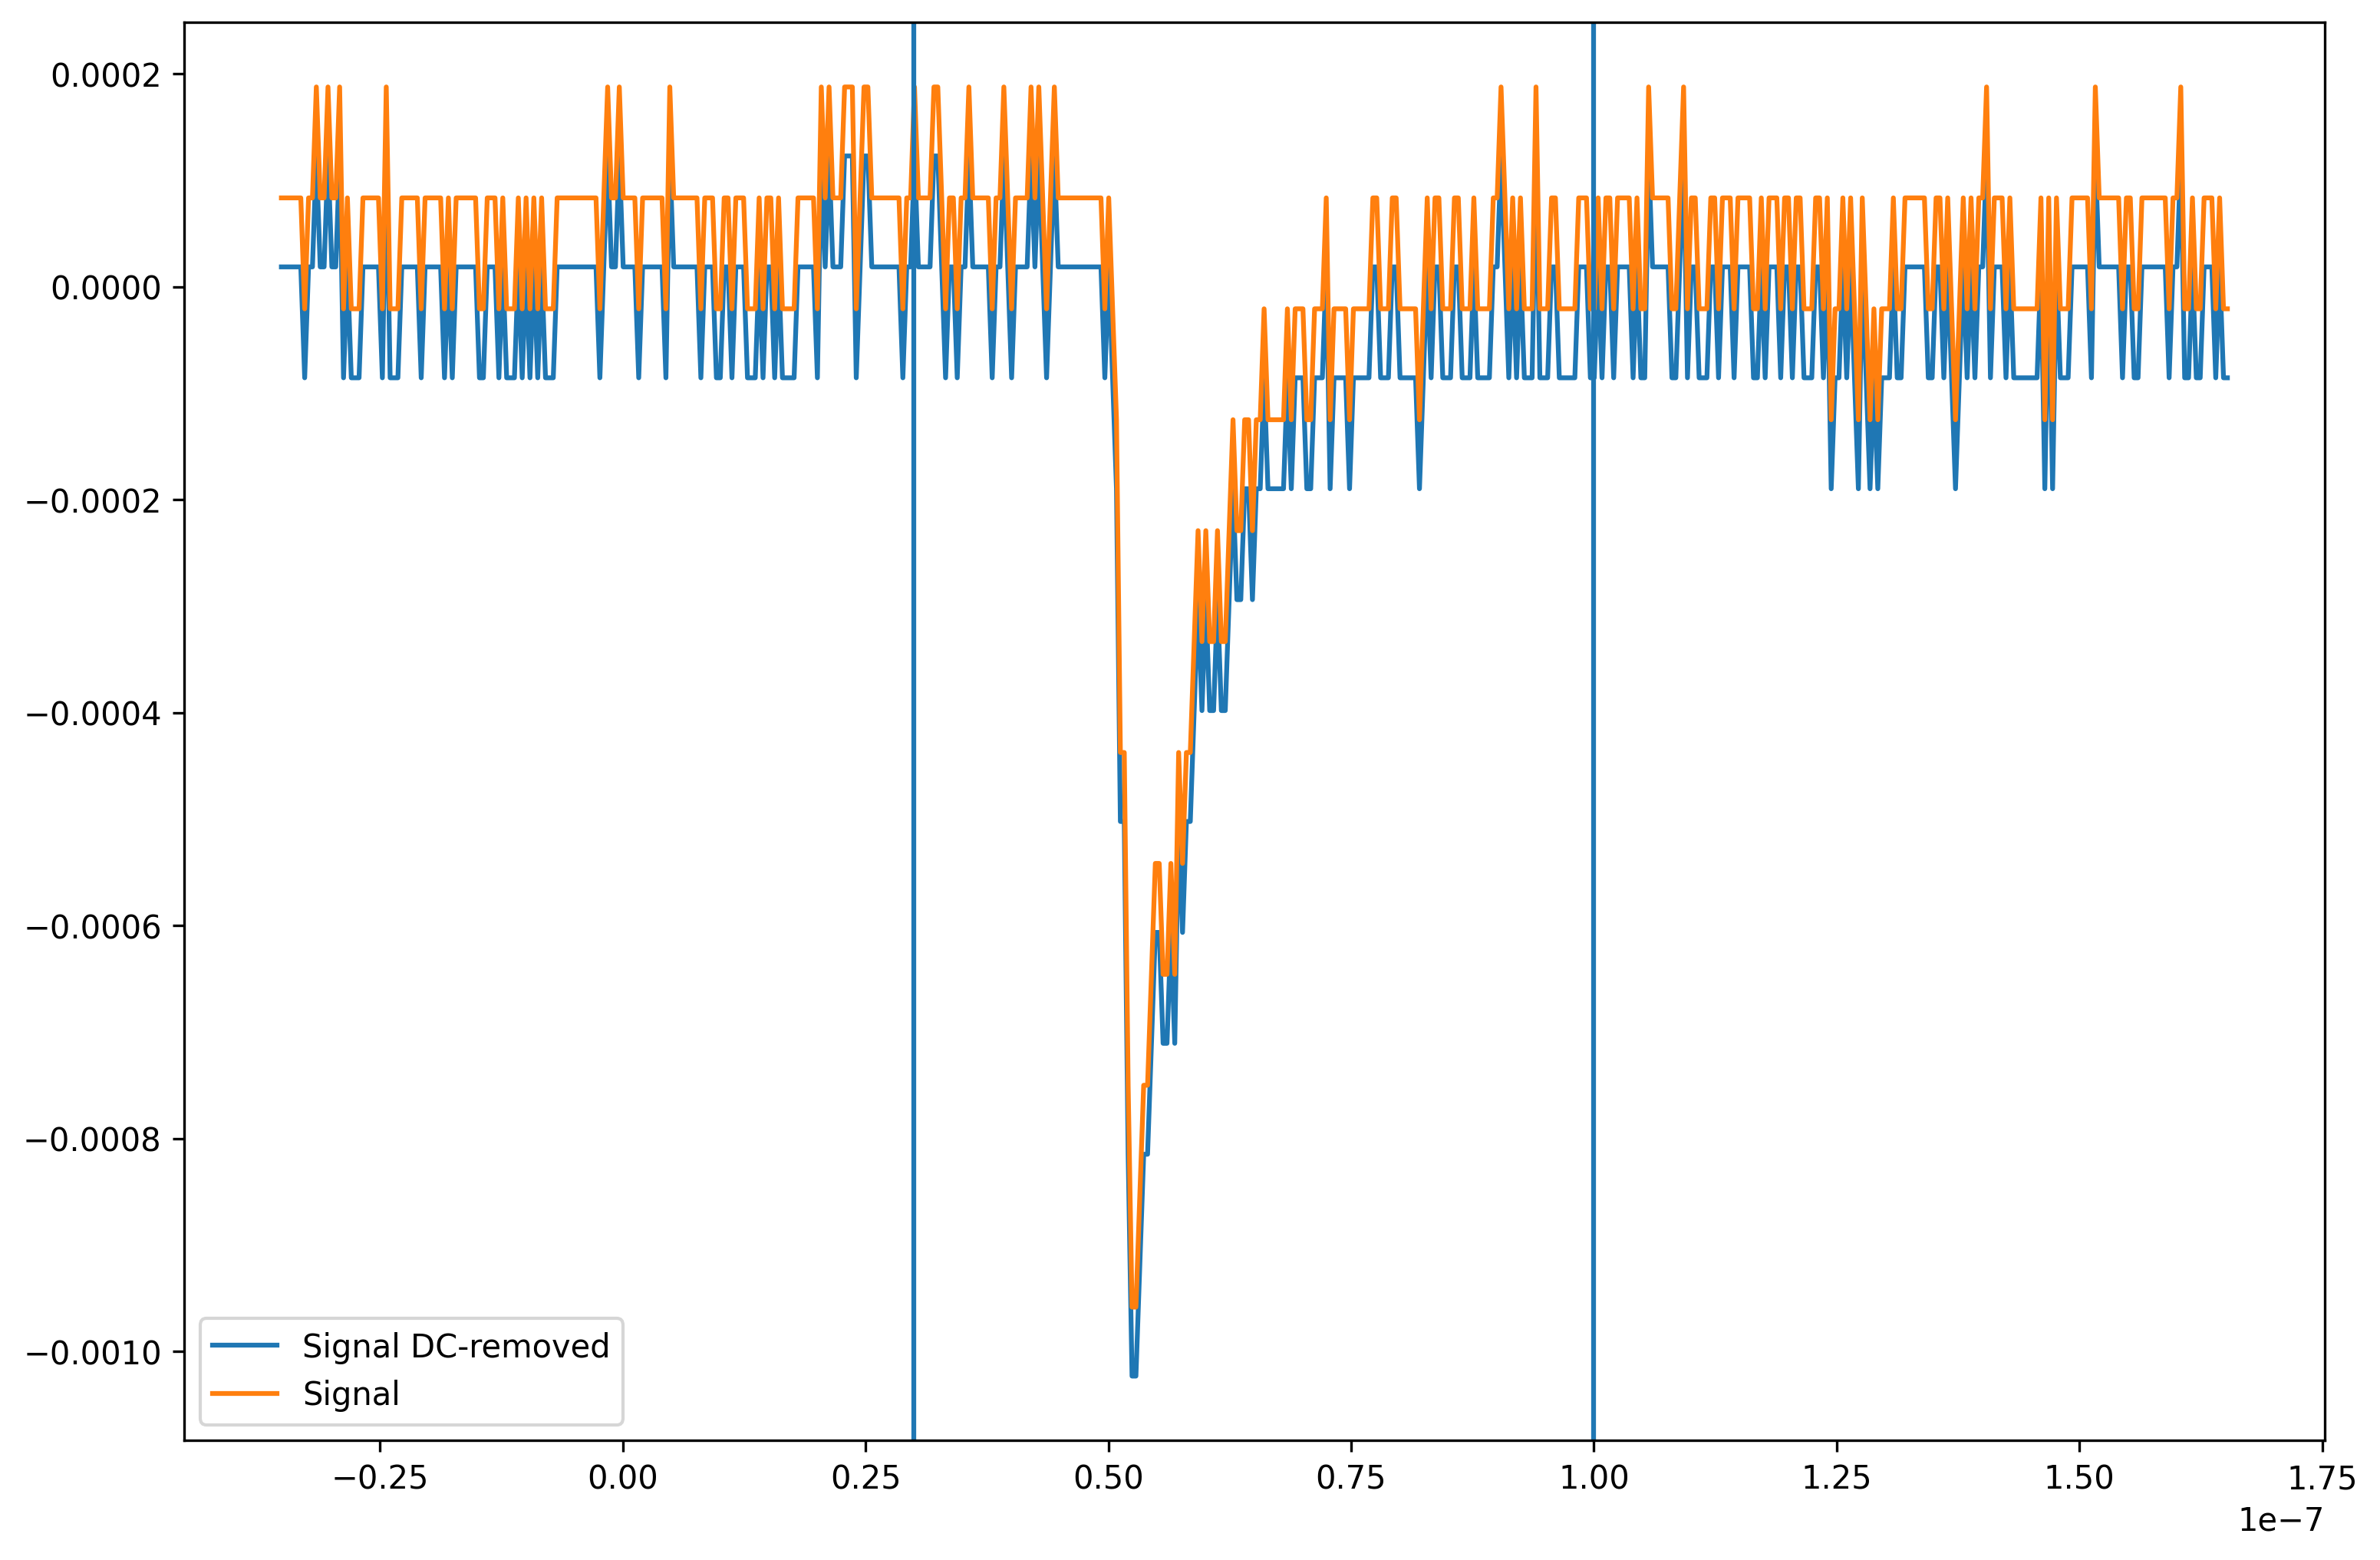

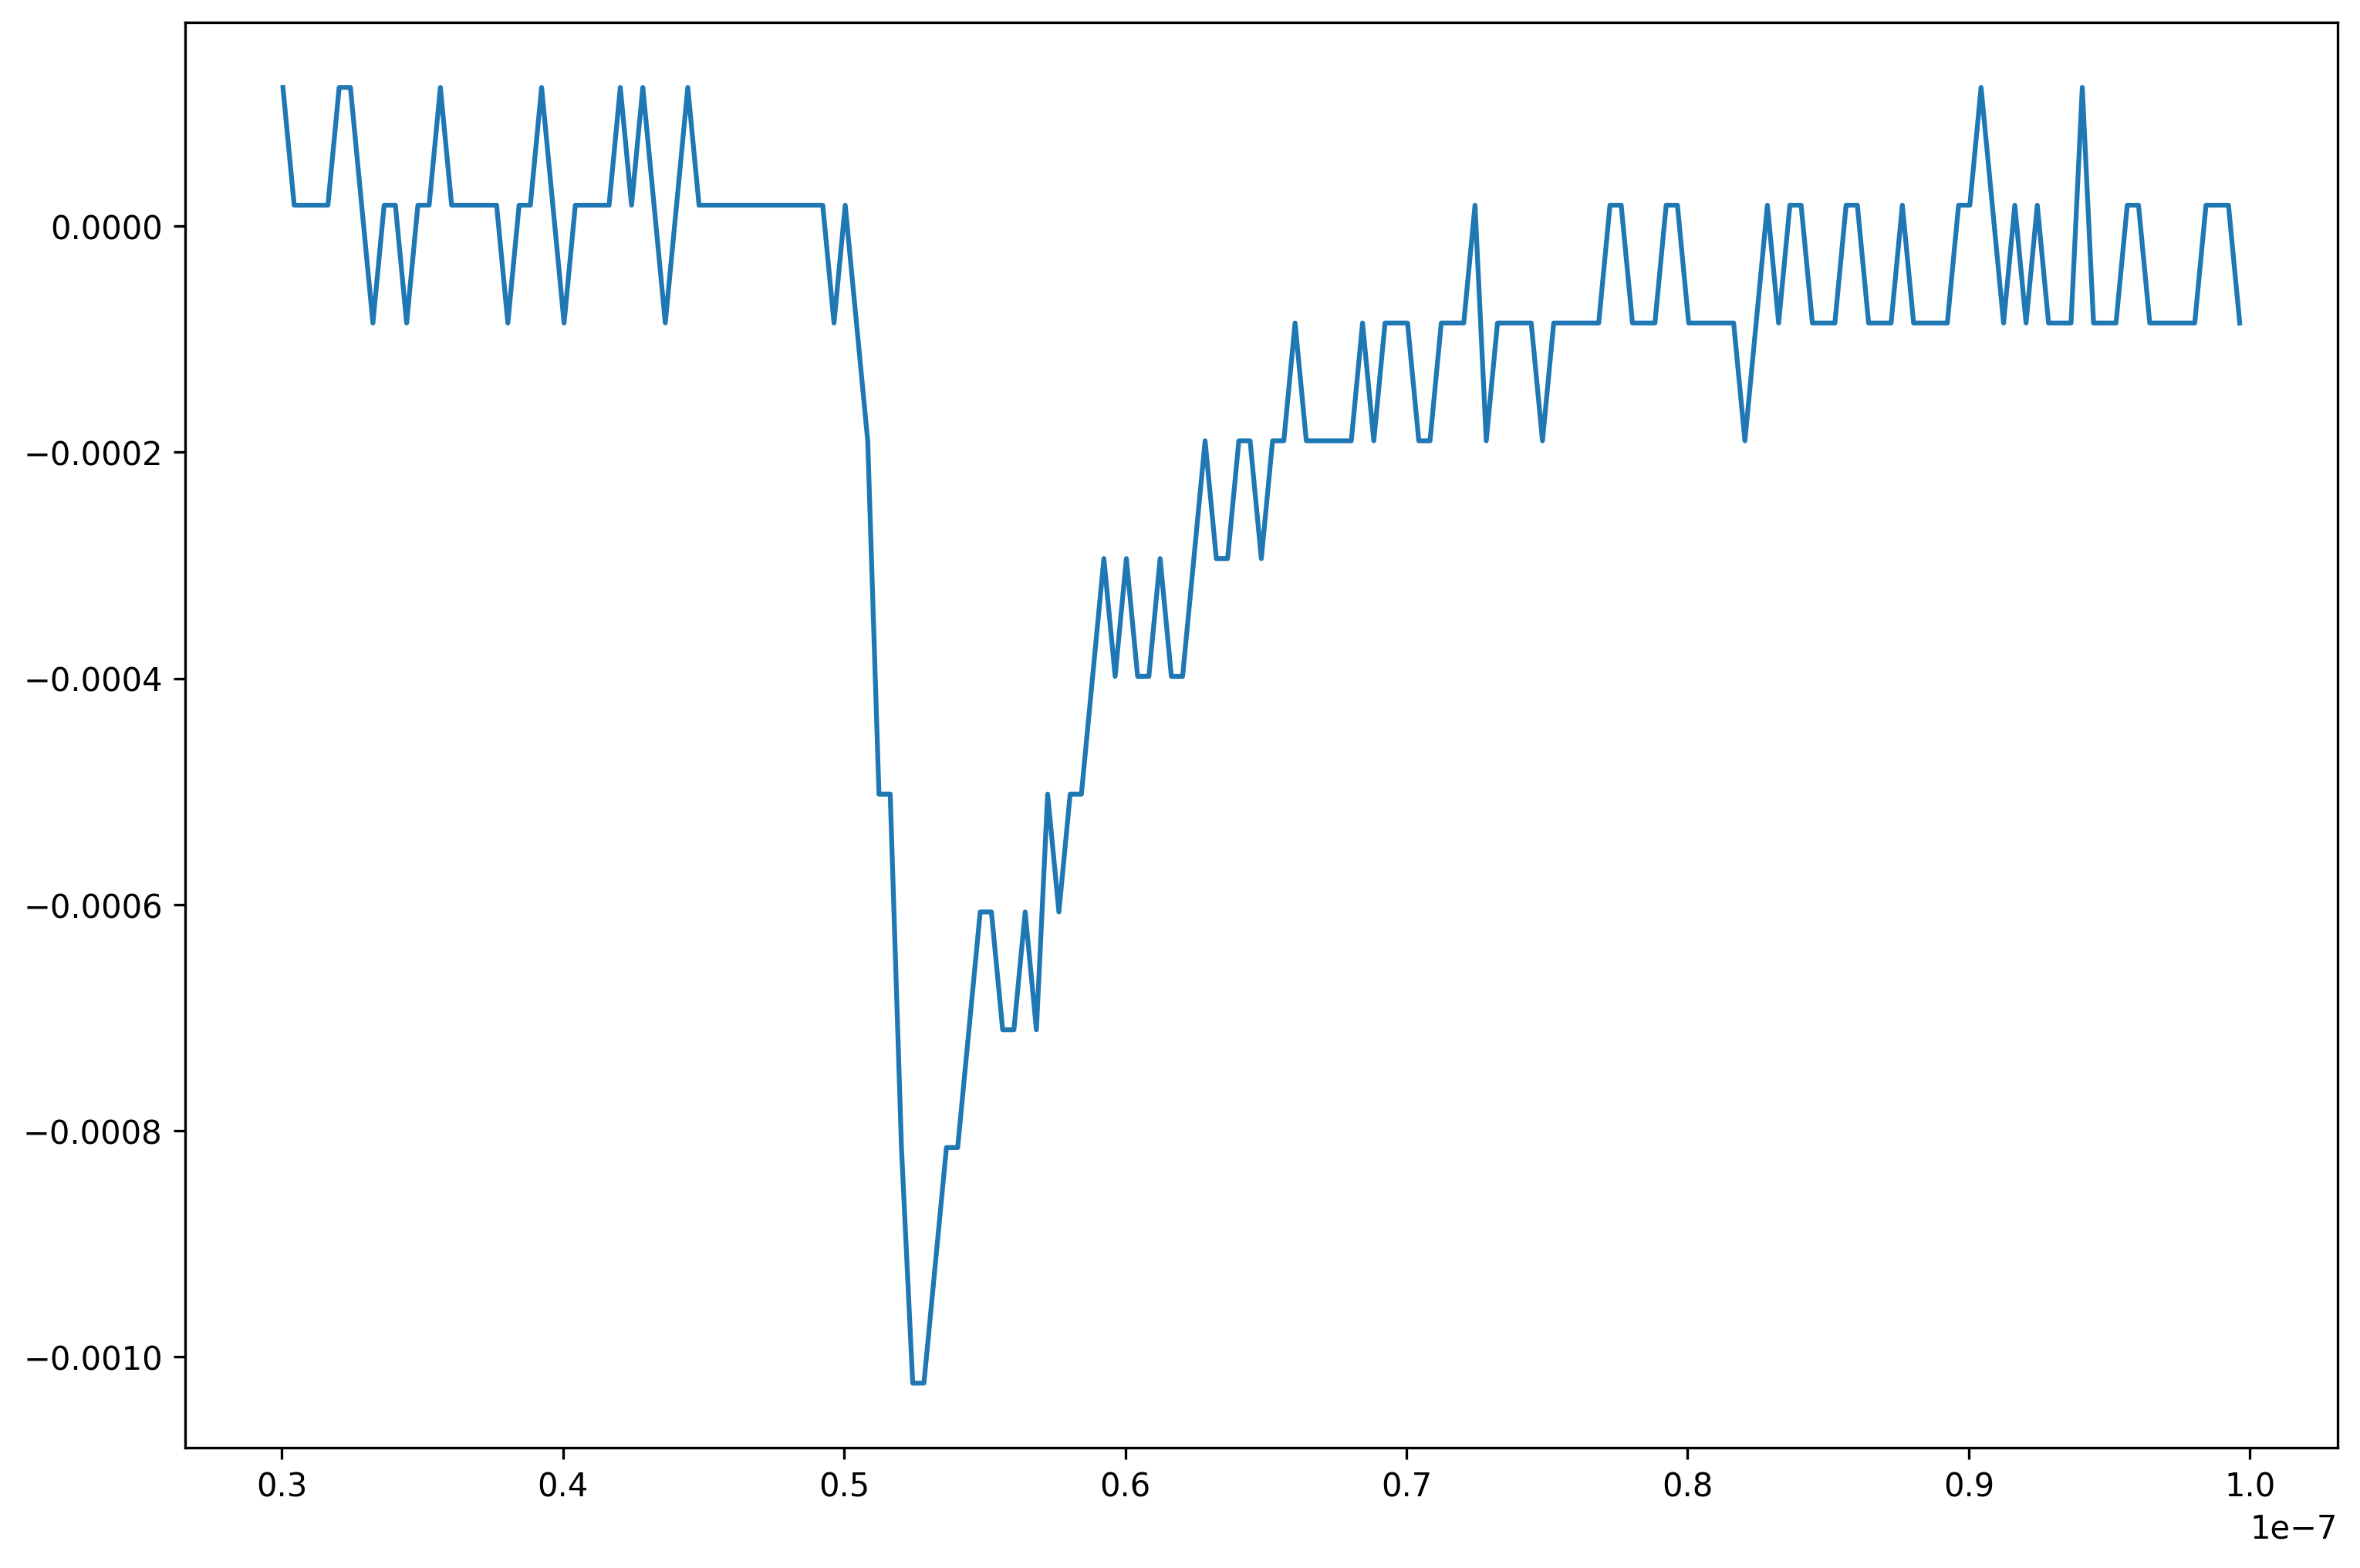

(-9.41845514269939e-12, -1162772.239839431)

In [7]:
getArea(pmt3[1],0.3e-7,1e-7,p=True)

mean = -3822279.618006921 stdev = 1930852.727413964


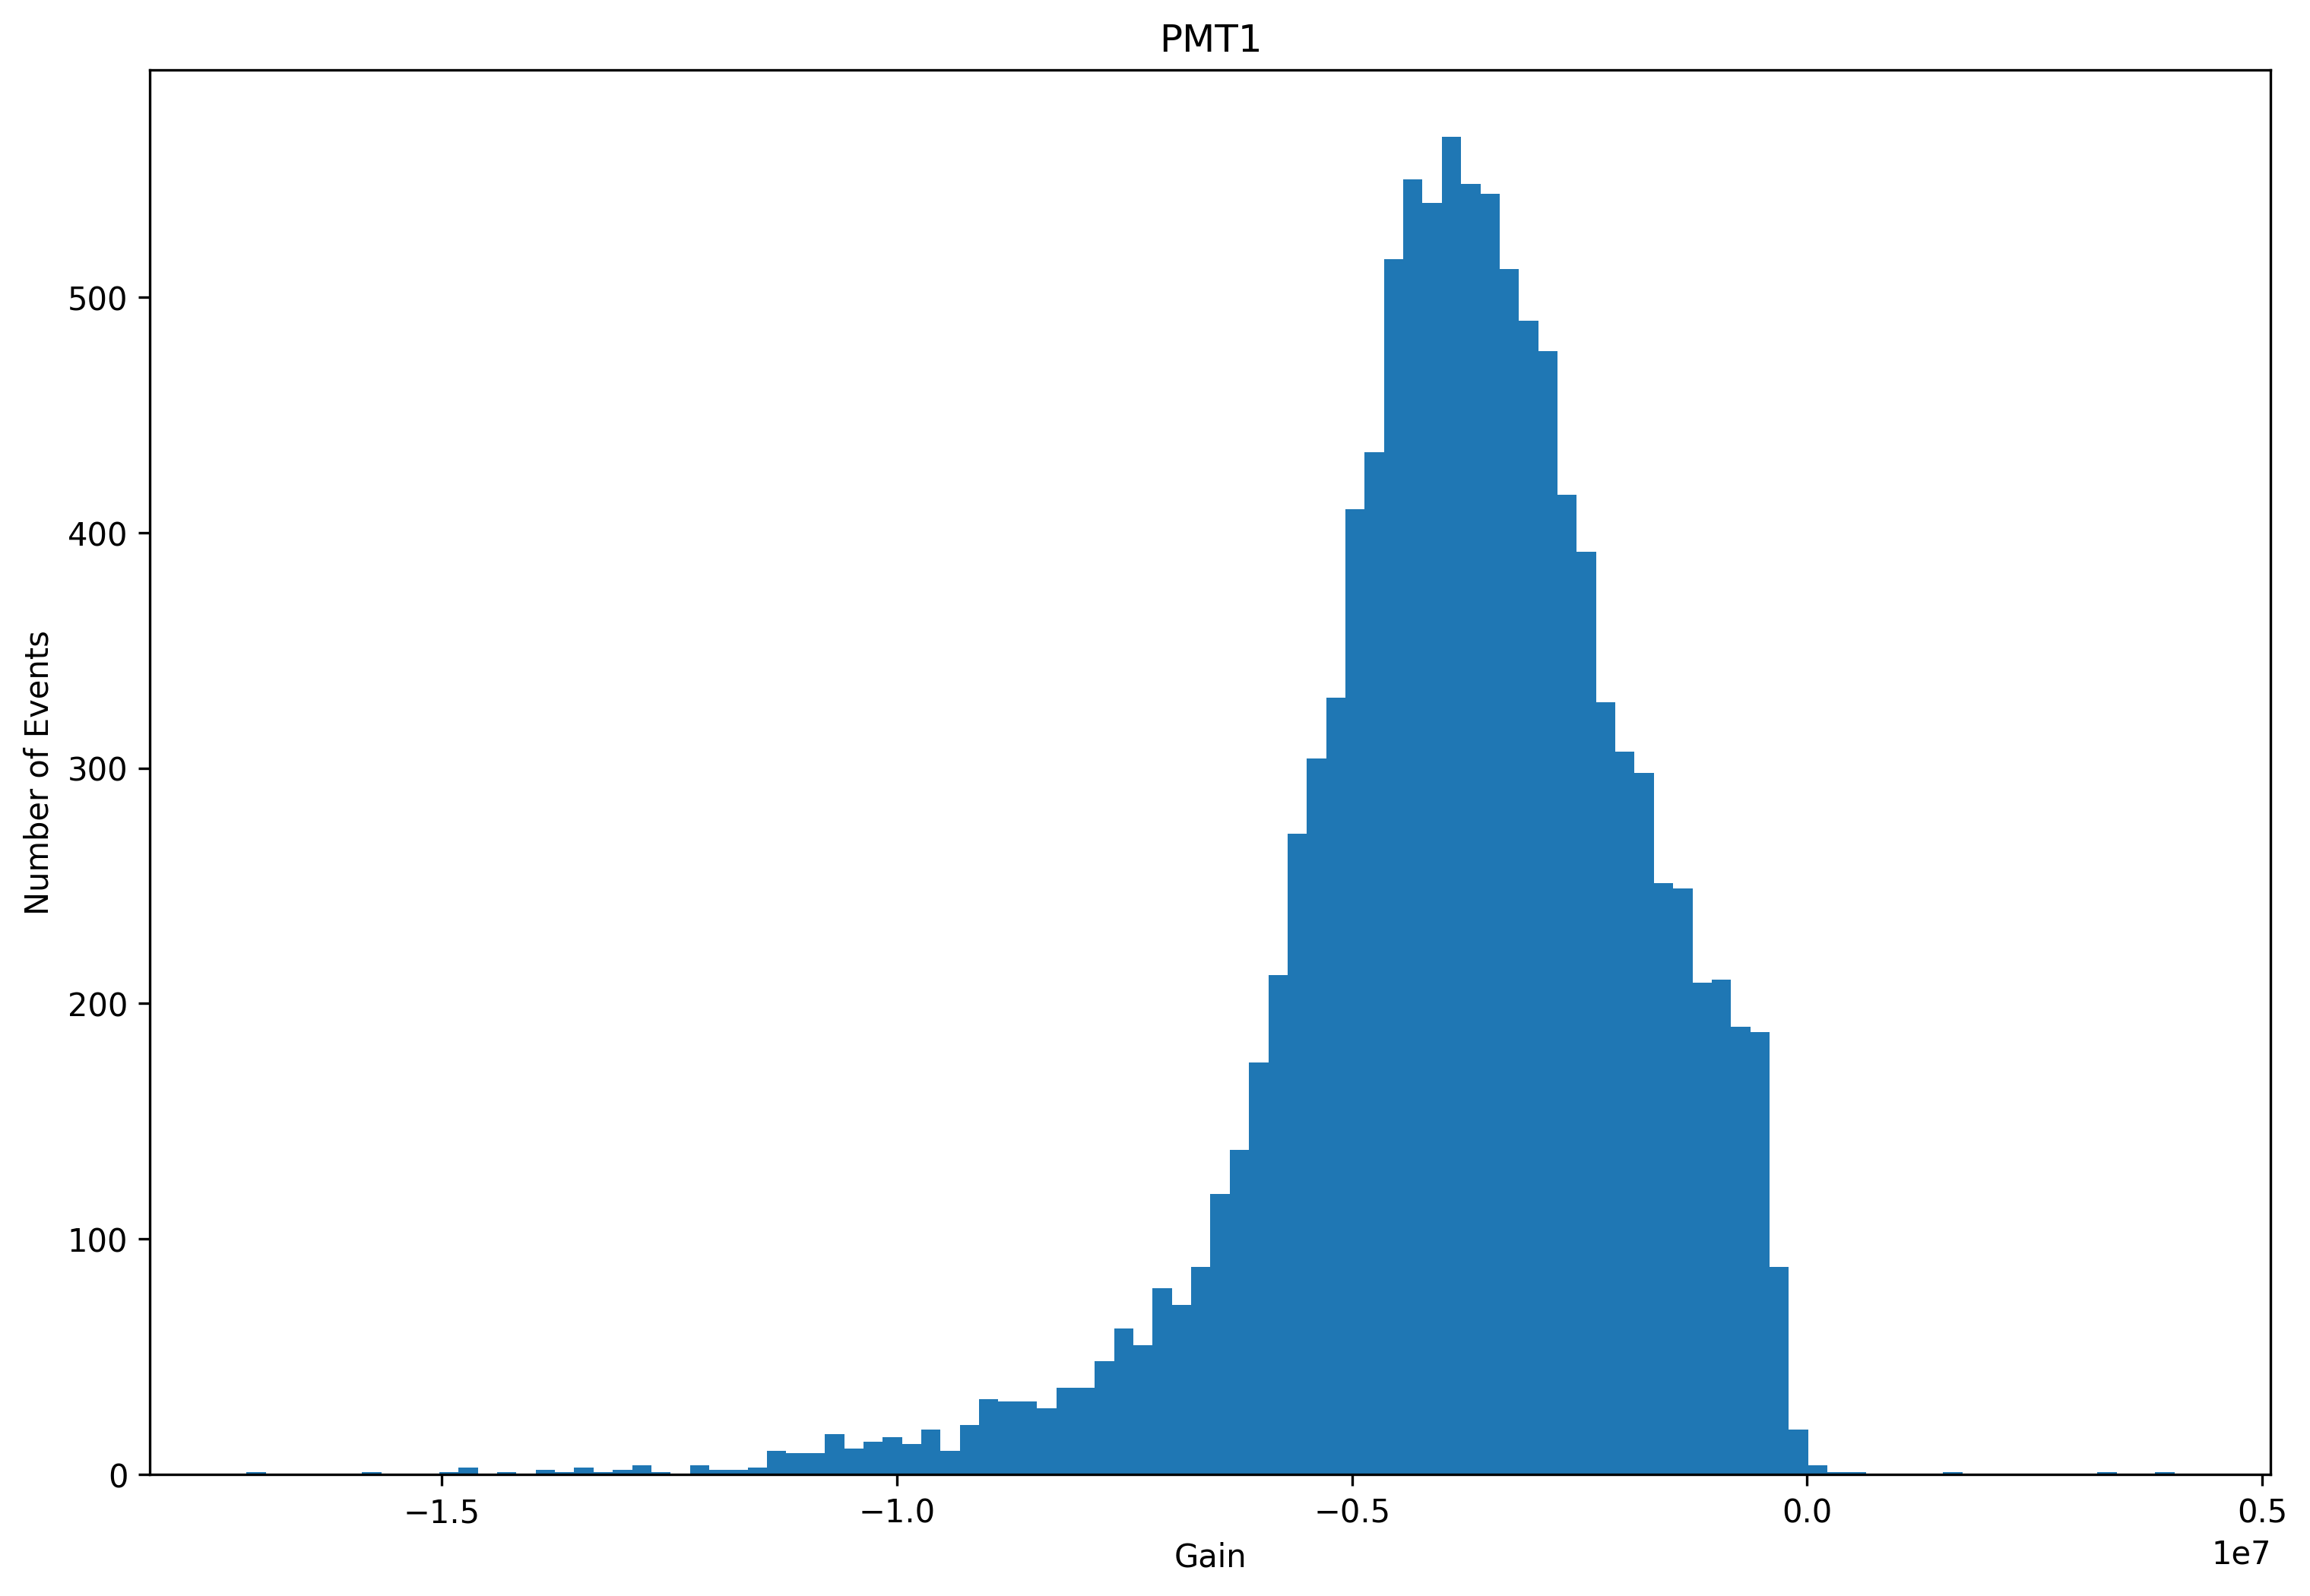

In [8]:
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1")
plt.ylabel("Number of Events")
plt.xlabel("Gain")
#plt.semilogx()
plt.hist(g[1],bins=100)
mean=st.mean(g[1])
stdev=st.stdev(g[1])
print(f"mean = {mean} stdev = {stdev}")

mean = -5.000858332194429e-12 stdev = 1.3029674828855687e-11


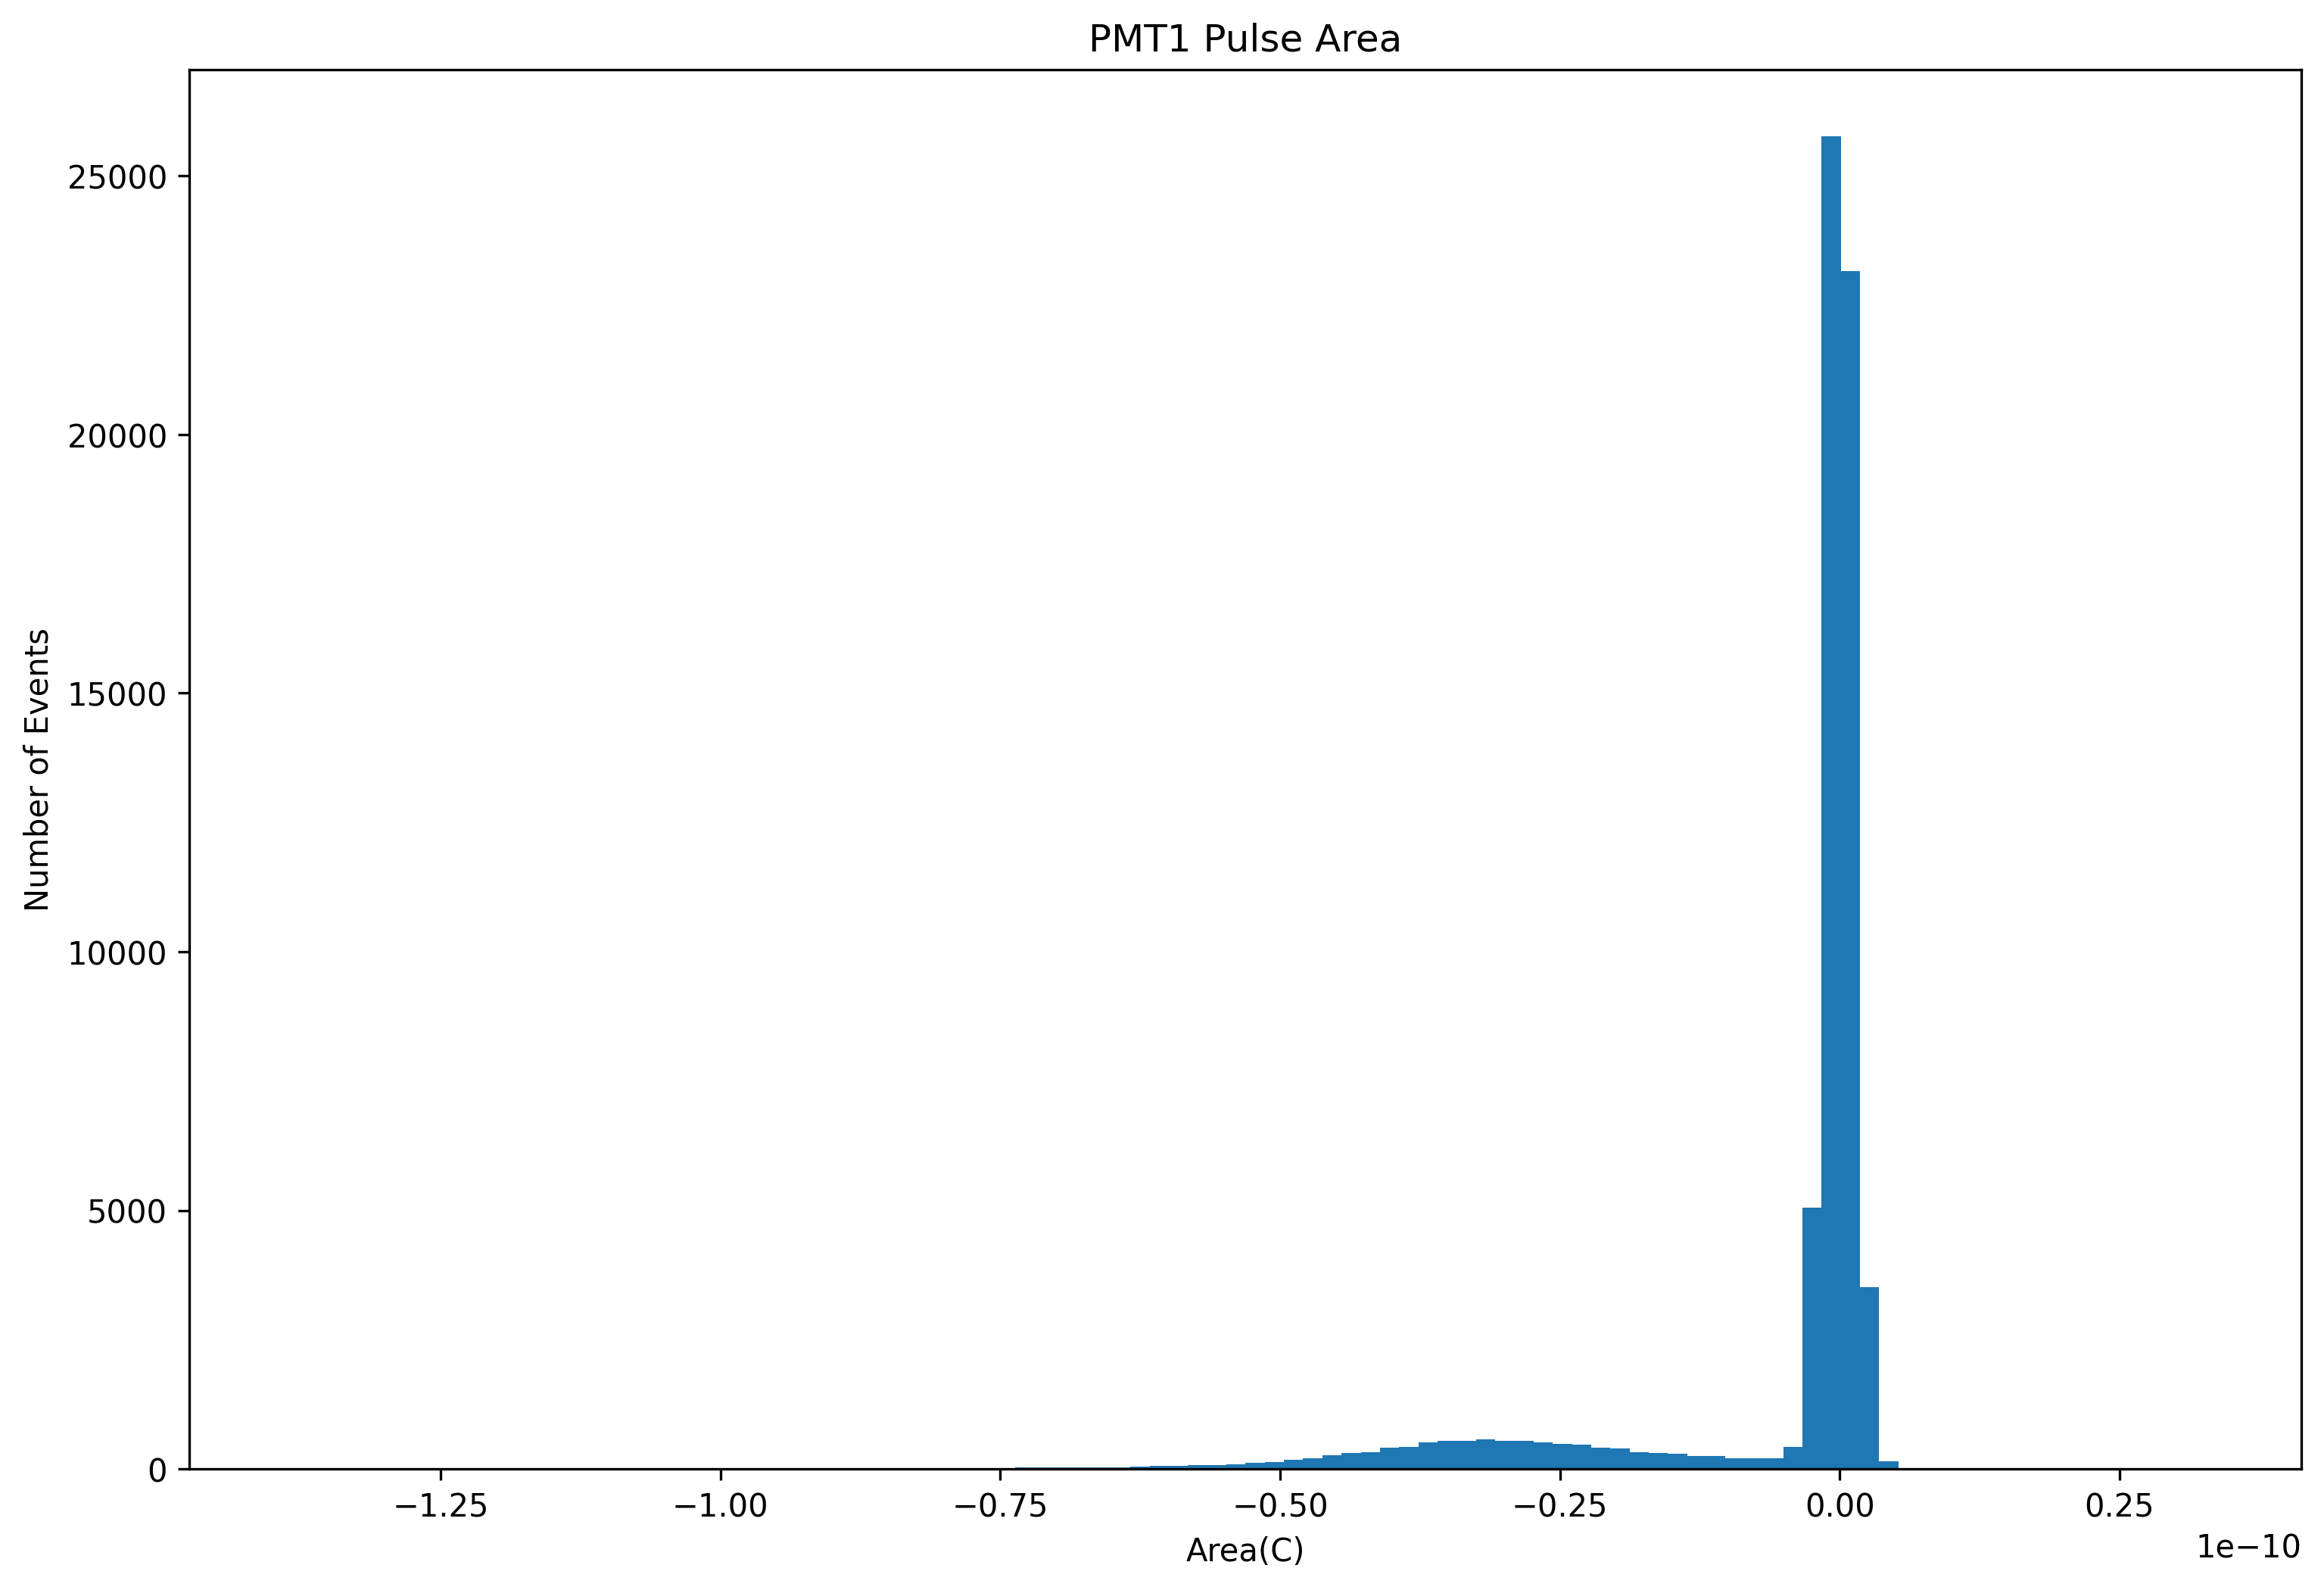

In [15]:
#### PMT1 Area ￼
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1 Pulse Area")
plt.ylabel("Number of Events")
plt.xlabel("Area(C)")
area=MultiAreaGain(pmt1,0.3e-7,1e-7,9999)  ## xlow,xhigh (time) , minpulse(volt)
plt.hist(area[0],bins=100)
#plt.semilogy()
mean=st.mean(area[0])
stdev=st.stdev(area[0])
print(f"mean = {mean} stdev = {stdev}")

mean = -0.0006558415388304068 stdev = 0.0012967004537674956


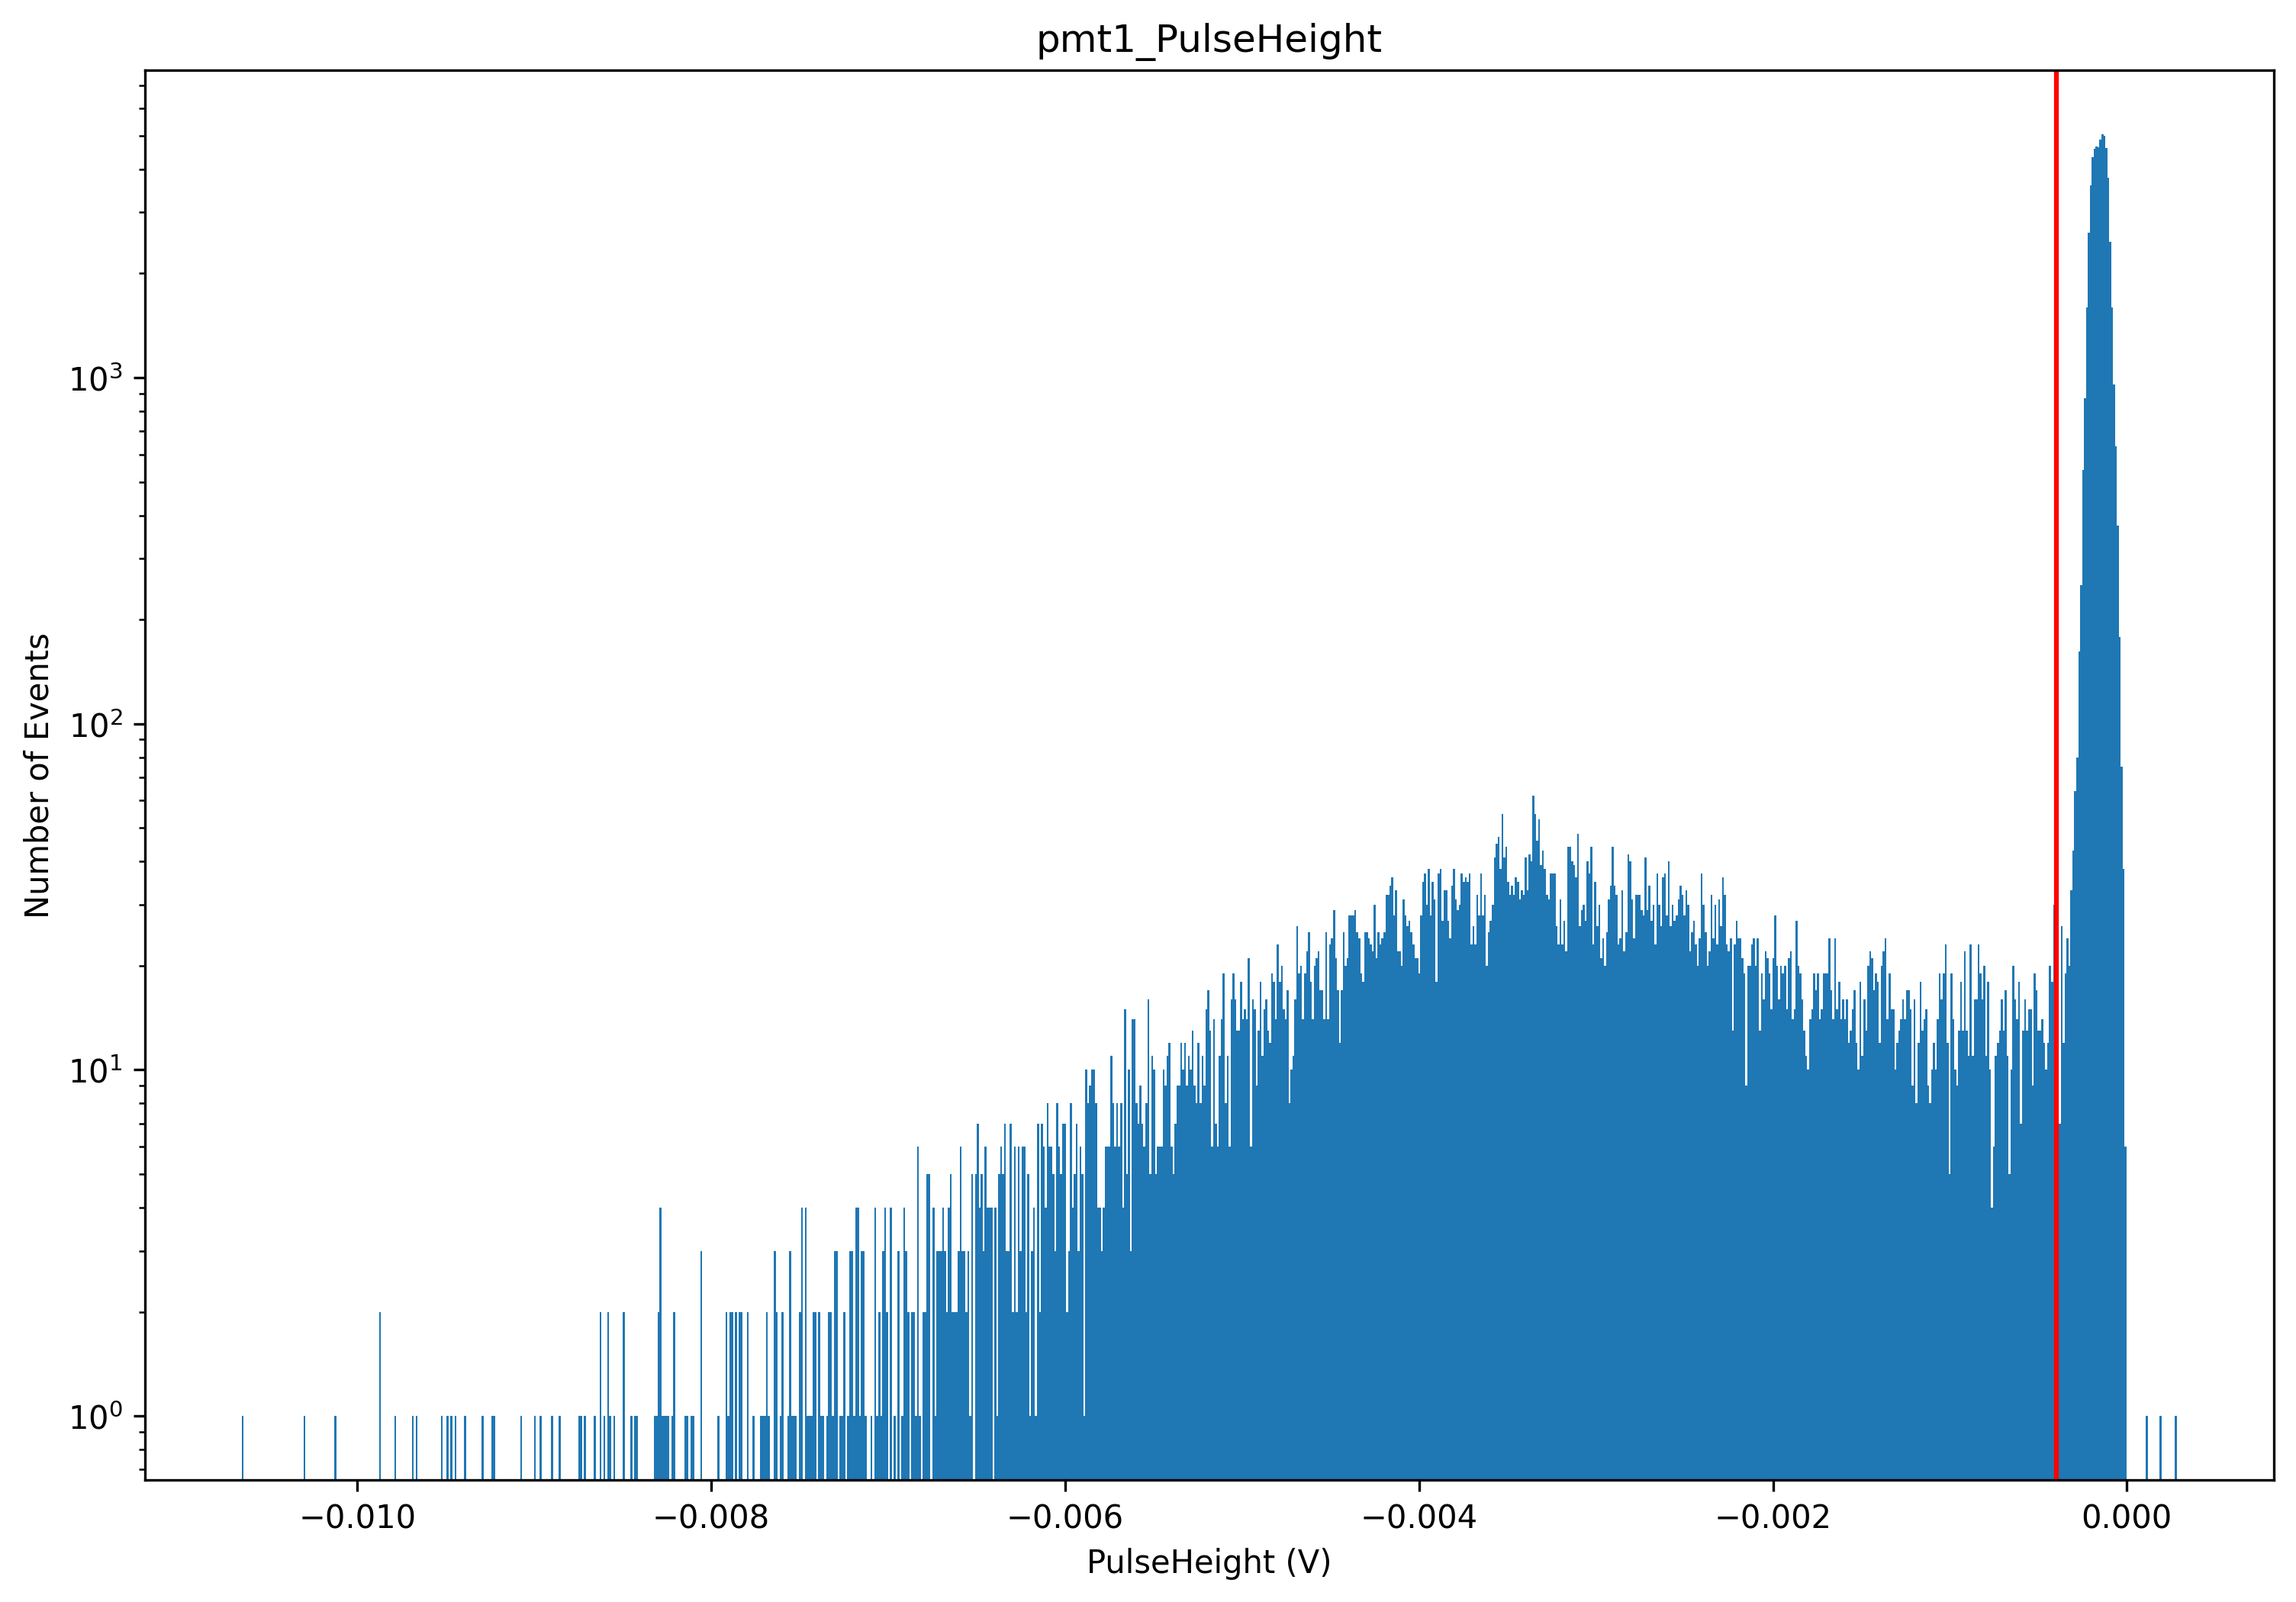

In [16]:
Pmt1PulseHeight=MultiPulseHeightDist(pmt1,0.3e-7,1e-7,9999)
HistIT(Pmt1PulseHeight[1],"pmt1_PulseHeight",1000,"PulseHeight (V)",-0.0004)

In [11]:
##### PMT3 #####


g3=MultiAreaGain(pmt3,0.3e-7,1e-7,-0.0004)  ## xlow,xhigh (time) , minpulse(volt)

Gain mean = -2545330.7079793504 stdev = 1469420.2147873074


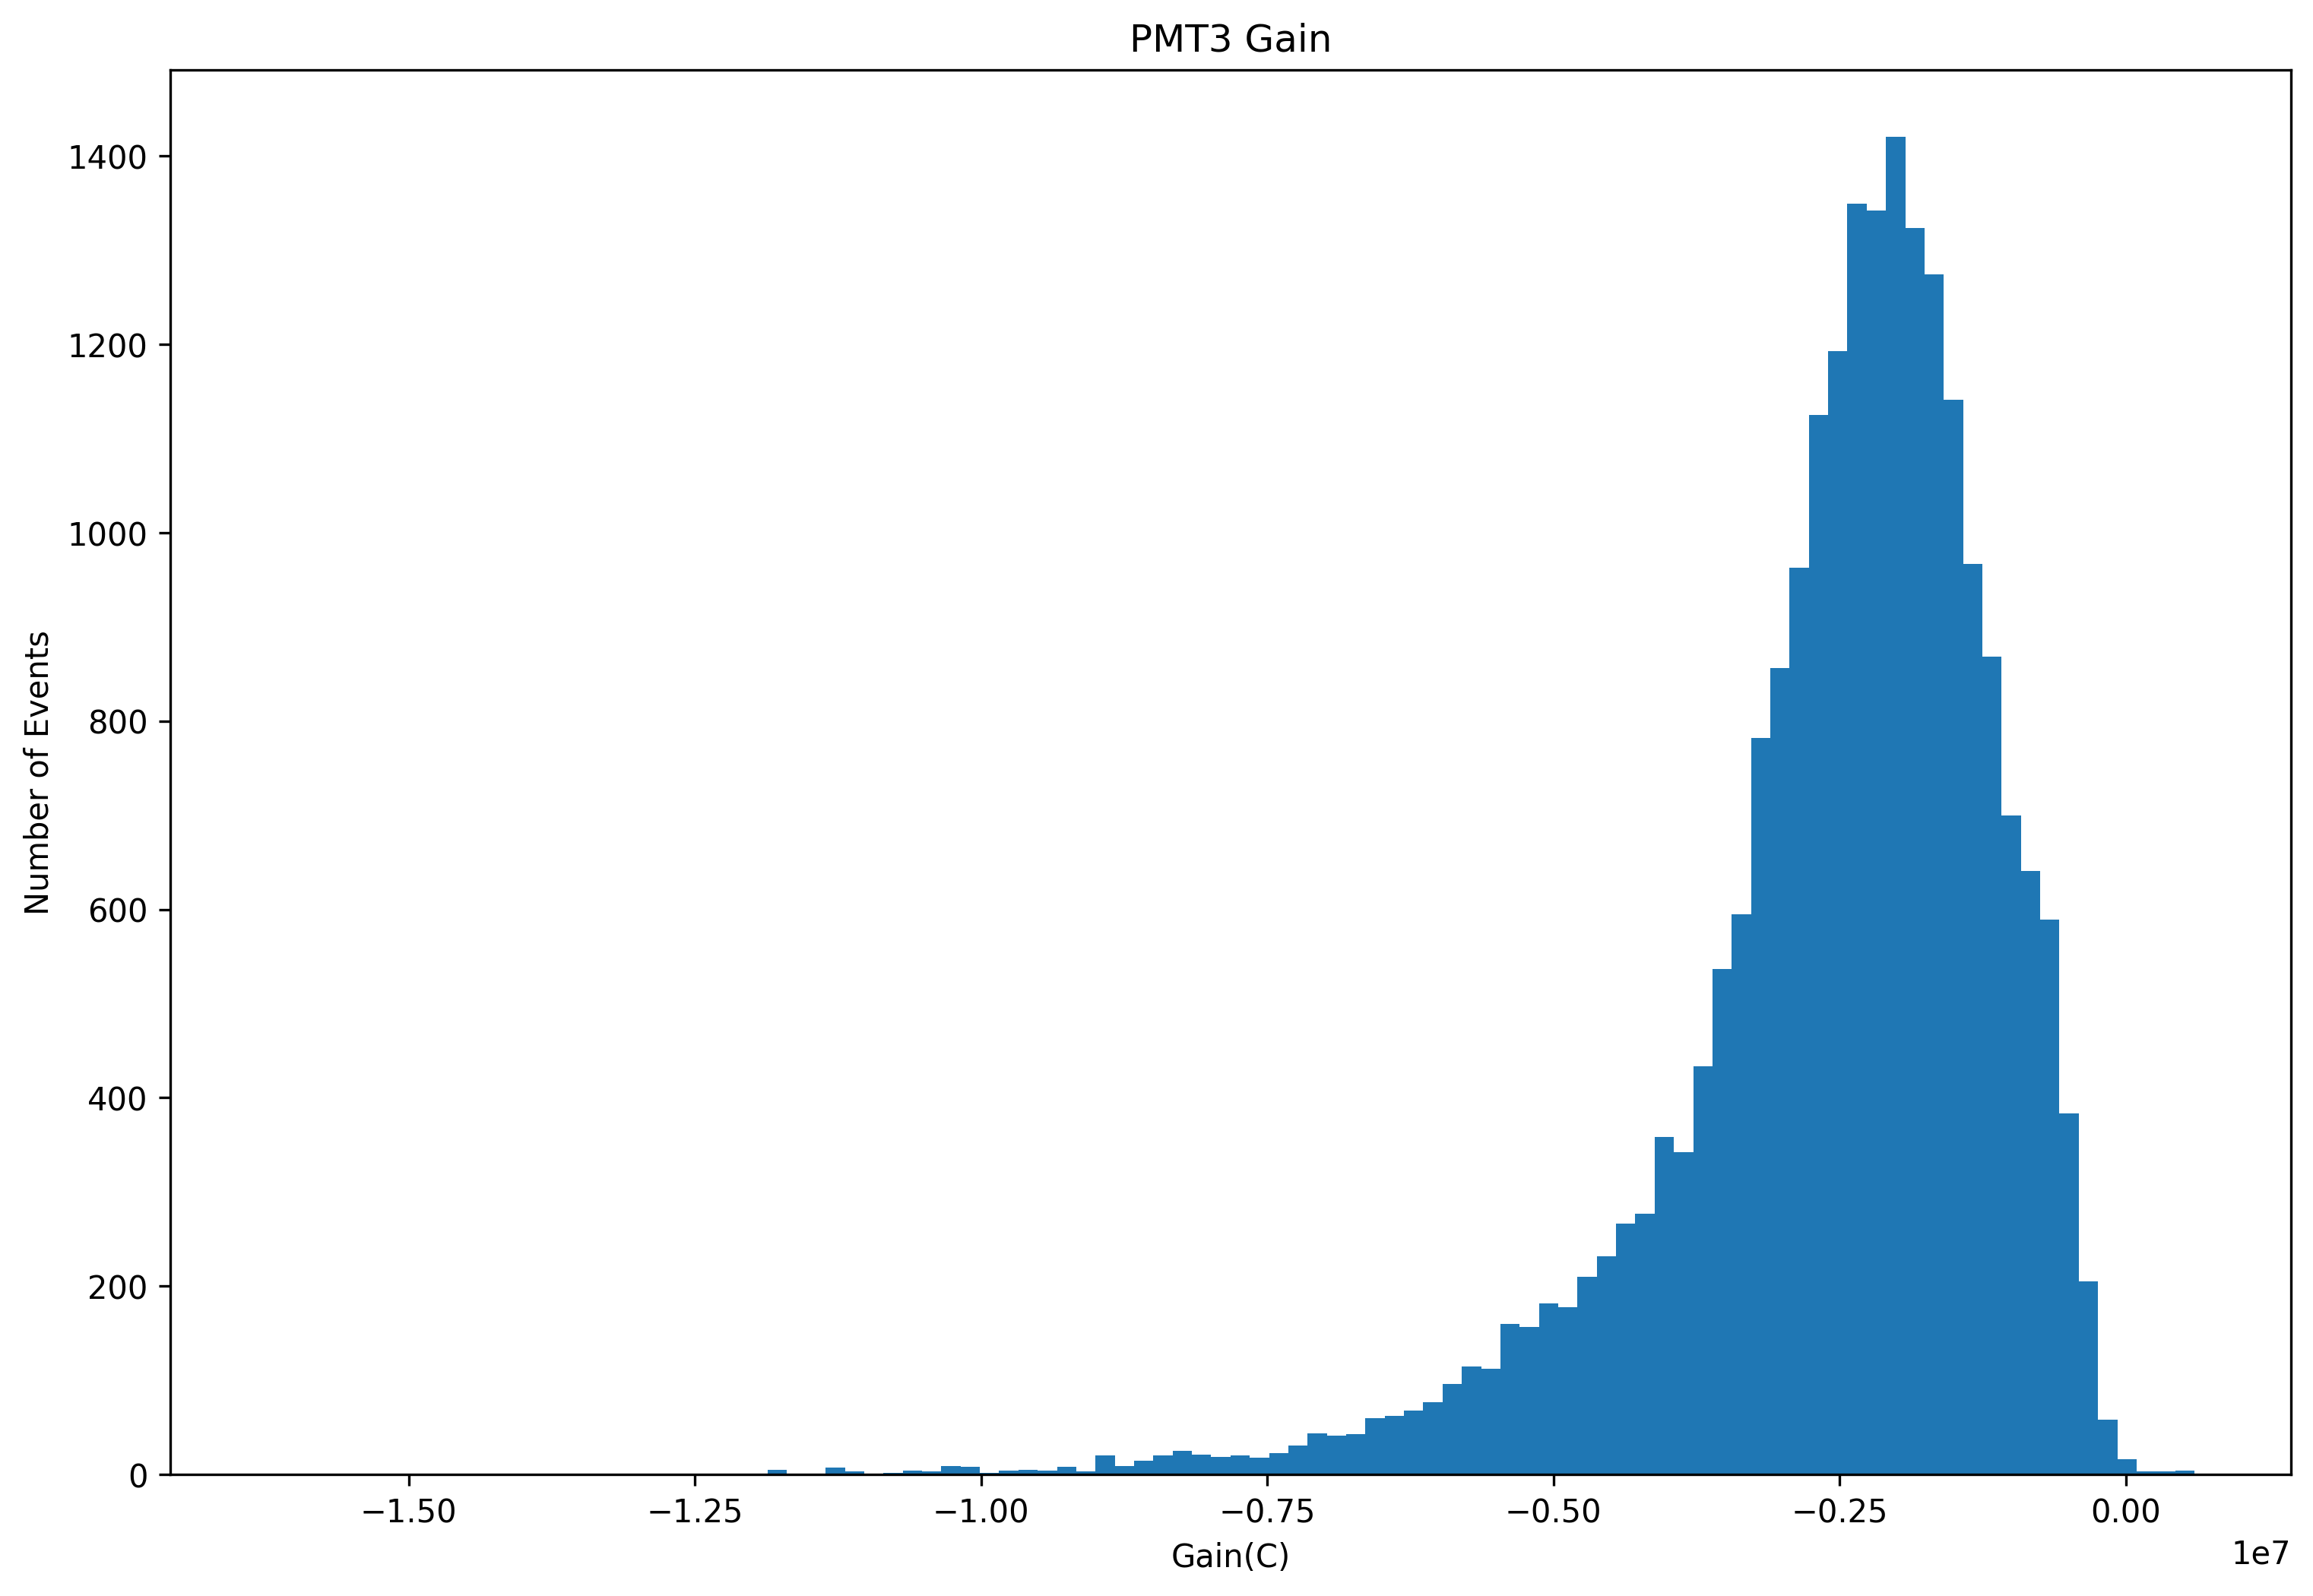

In [12]:
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3 Gain")
plt.ylabel("Number of Events")
plt.xlabel("Gain(C)")
plt.hist(g3[1],bins=100)
#plt.semilogx()
mean=st.mean(g3[1])
stdev=st.stdev(g3[1])
print(f"Gain mean = {mean} stdev = {stdev}")

Area mean = -6.680501785637215e-12 stdev = 1.186525601406051e-11


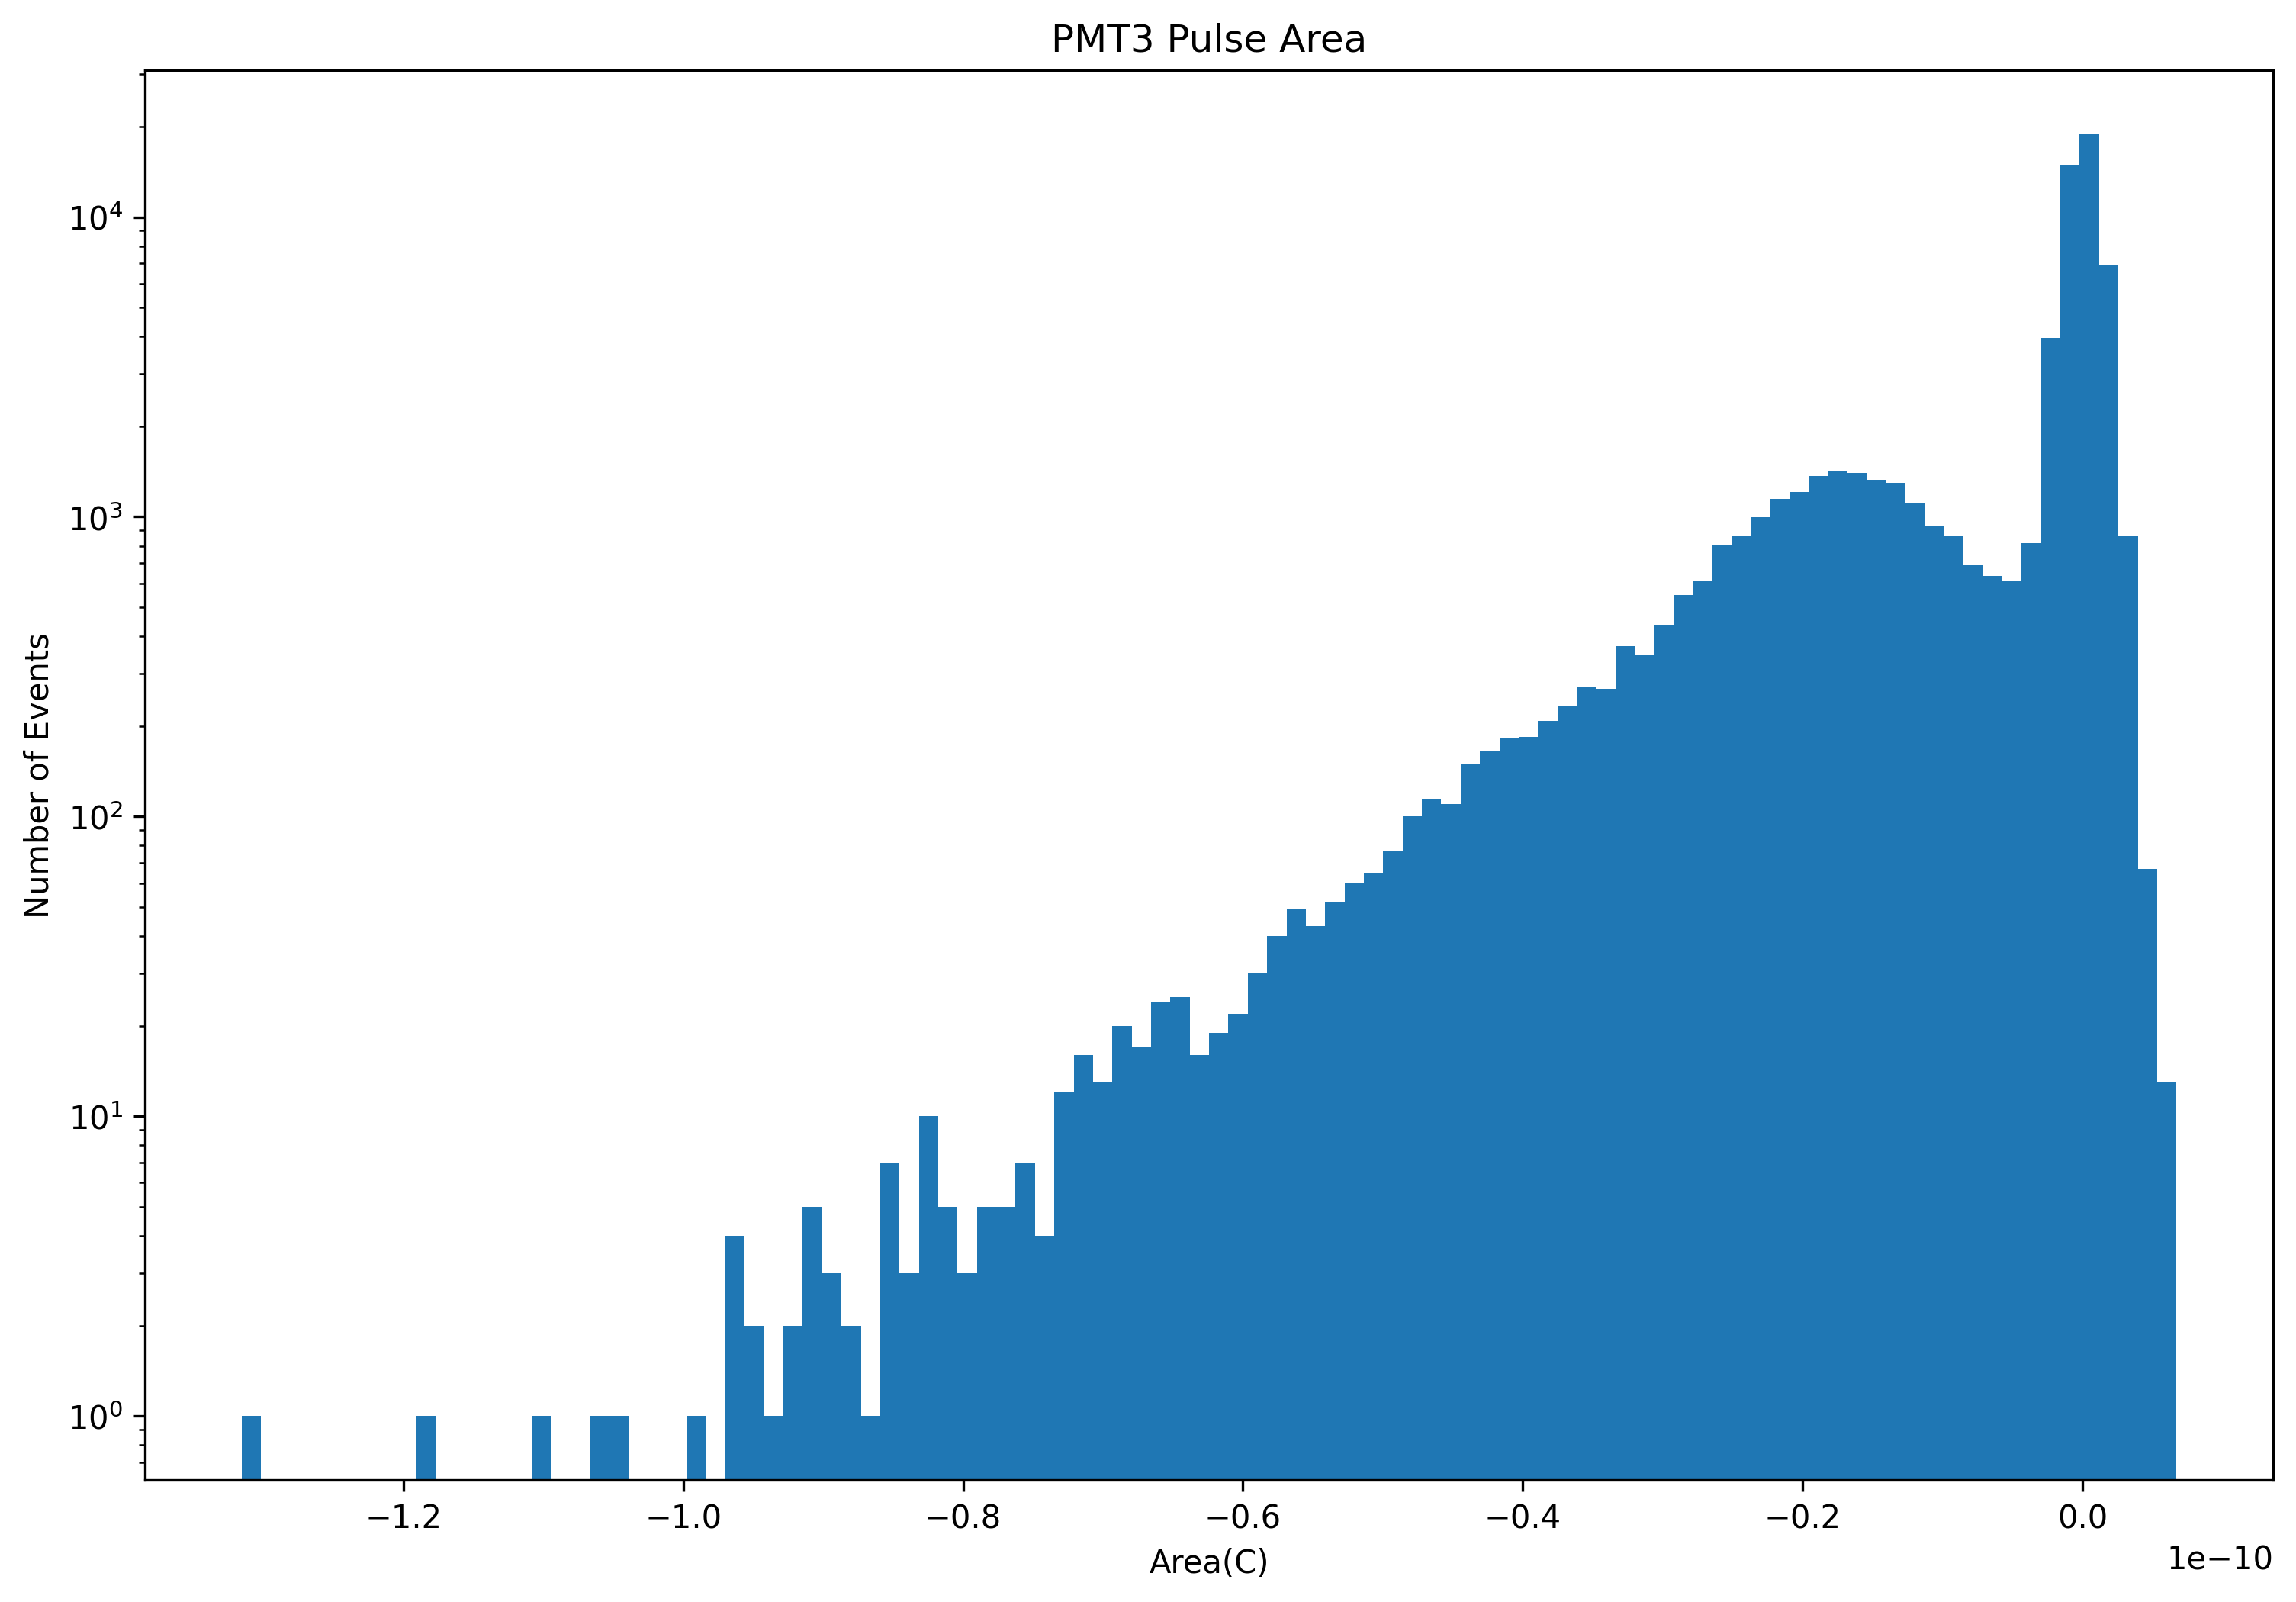

In [13]:
### PMT3 Area
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3 Pulse Area")
plt.ylabel("Number of Events")
plt.xlabel("Area(C)")
area3=MultiAreaGain(pmt3,0.3e-7,1e-7,9999)  ## xlow,xhigh (time) , minpulse(volt)
plt.hist(area3[0],bins=100)
plt.semilogy()
mean=st.mean(area3[0])
stdev=st.stdev(area3[0])
print(f"Area mean = {mean} stdev = {stdev}")

mean = -0.0008093031298338903 stdev = 0.0011177974990016287


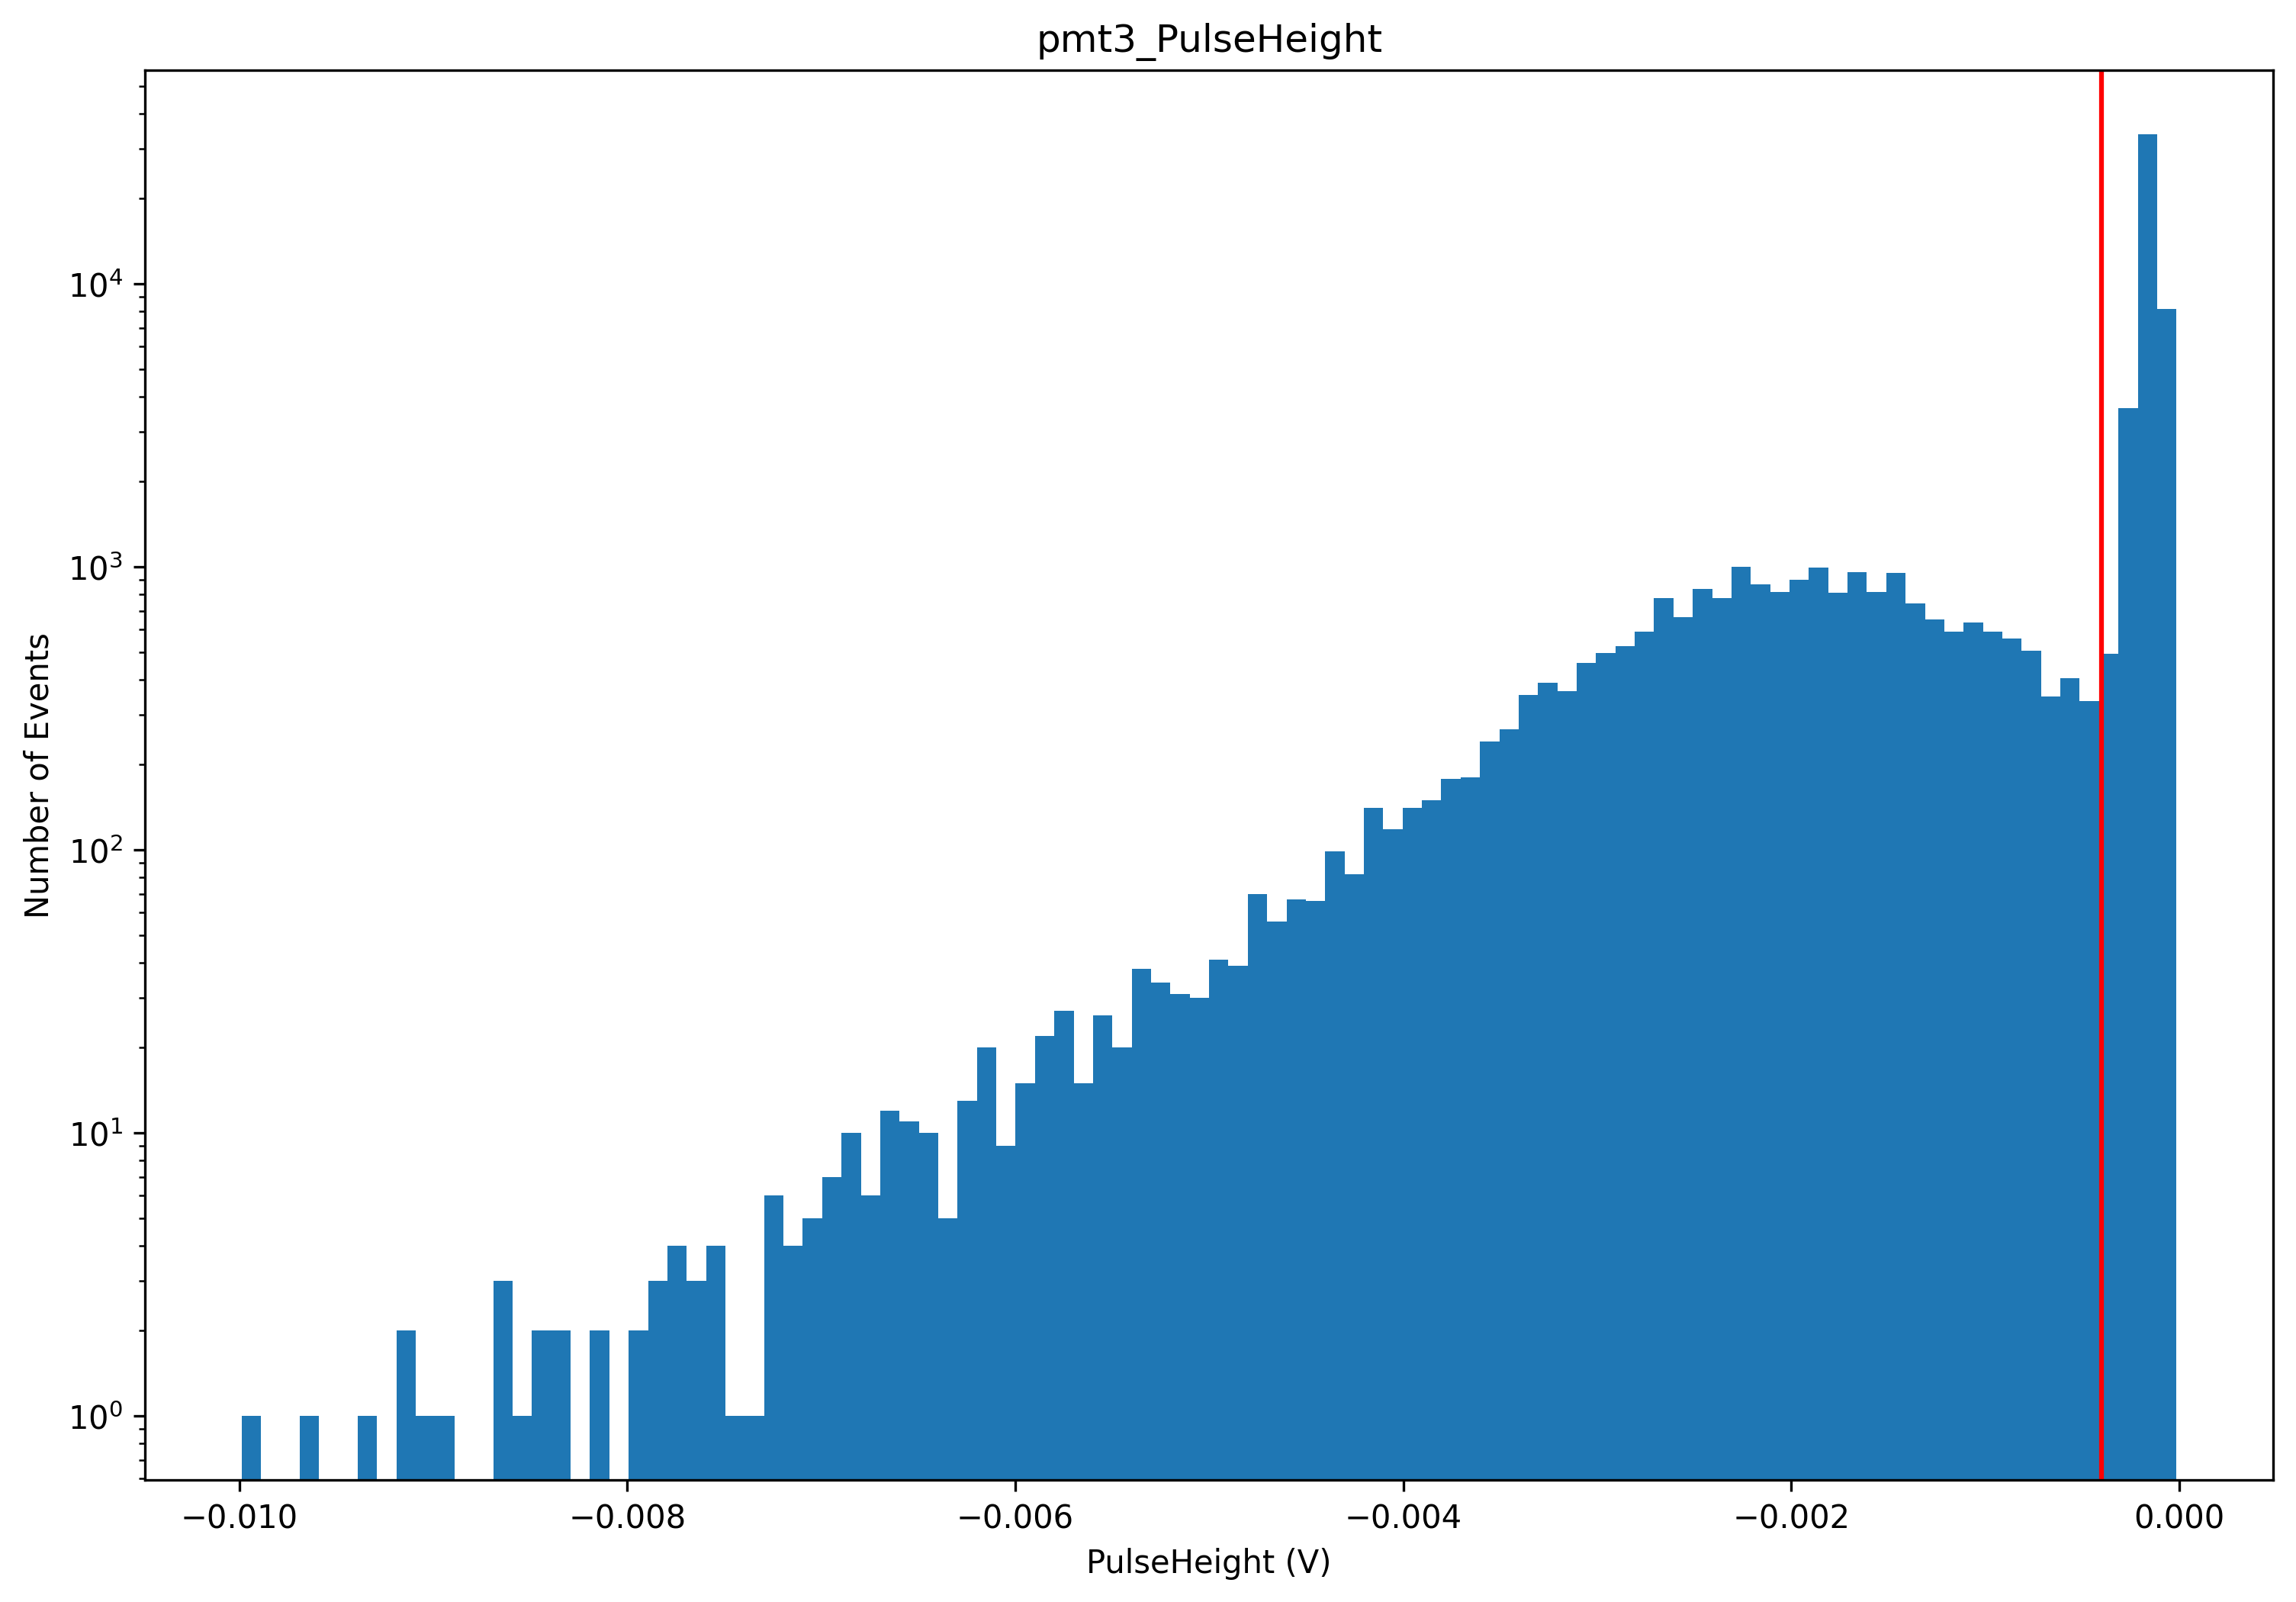

In [14]:
Pmt3PulseHeight=MultiPulseHeightDist(pmt3,0.3e-7,1e-7,9999)
HistIT(Pmt3PulseHeight[1],"pmt3_PulseHeight",100,"PulseHeight (V)",-0.0004)